### Introduction

In this kernel I use XGBRegressor from XGBoost library to predict future prices of stocks using technical indicator as features. If you are looking for an explanation of indicators (e.g. moving averages, RSI, MACD) used below, please refer to [articles on Investopedia](https://www.investopedia.com/technical-analysis-4689657) or [this notebook of mine](https://www.kaggle.com/mtszkw/analysis-and-technical-indicators-for-trading-etfs) where I introduce and visualize various technical analysis concepts.

In [ ]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV


# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)


: 

In [41]:
ETF_NAME = 'TNA.txt'

df = pd.read_csv(ETF_NAME, sep=',')

df['Date'] = pd.to_datetime(df['Date'])
df.index = range(len(df))

df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2015-08-07,40.040001,40.345001,38.970001,39.814999,39.246994,9382600
1,1,2015-08-10,40.240002,41.380001,40.200001,41.119999,40.533375,7717800
2,2,2015-08-11,40.334999,40.935001,39.500000,40.075001,39.503288,11995800
3,3,2015-08-12,39.380001,40.180000,37.834999,39.884998,39.316002,14436600
4,4,2015-08-13,39.959999,40.430000,39.250000,39.470001,38.906918,7886400


### OHLC Chart

I start with drawing an OHLC (open/high/low/close) chart to get a sense of historical prices. Below OHLC I draw Volume chart which shows number of stocks traded each day. In my previous notebook (linked above) I explain importance of OHLC and Volume charts in technical analysis.

In [42]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

### Decomposition

### Technical indicators

#### Moving Averages

I'm calculating few moving averages to be used as features: $SMA_{5}$, $SMA_{10}$, $SMA_{15}$, $SMA_{30}$ and $EMA_{9}$.

In [43]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

#### Relative Strength Index

I'll add RSI indicator to predict whether a stock is overbought/oversold.

In [44]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

#### MACD

In [45]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

### Shift label column

Because I want to predict the next day price, after calculating all features for day $D_{i}$, I shift Close price column by -1 rows. After doing that, for day $D_{i}$ we have features from the same timestamp e.g. $RSI_{i}$, but the price $C_{i+1}$ from upcoming day.

In [46]:
df['close_close_change'] = df['Close'].pct_change()
df['close_close_change'] = df['close_close_change'].shift(-2)
df['target'] = np.where(df['close_close_change'] > 0.0, 1, 0)
df.drop(['close_close_change'], axis=1, inplace=True)
print(df['target'].head())
df[-3:]

0    0
1    0
2    0
3    1
4    1
Name: target, dtype: int64


,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal,target
1994,1994,2023-07-10,33.709999,35.619999,33.480000,35.590000,35.590000,11605200,33.769756,34.426001,33.766001,34.030000,33.267667,52.326468,0.626782,0.695936,1
1995,1995,2023-07-11,35.880001,36.770000,35.419998,36.560001,36.560001,14587700,33.951780,34.486001,34.159001,34.010667,33.462000,57.404690,0.764785,0.709706,0
1996,1996,2023-07-12,38.310001,38.470001,37.500000,37.759998,37.759998,19330600,34.212602,34.658001,34.627001,34.116000,33.712667,62.708335,0.959918,0.759748,0


### Drop invalid samples

Because of calculating moving averages and shifting label column, few rows will have invalid values i.e. we haven't calculated $SMA_{10}$ for the first 10 days. Moreover, after shifting Close price column, last row price is equal to 0 which is not true. Removing these samples should help.

In [47]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-2]      # Because of shifting close price

df.index = range(len(df))

Here I split stock data frame into three subsets: training ($70\%$), validation ($15\%$) and test ($15\%$) sets. I calculated split indices and create three separate frames (train_df, valid_df, test_df). All three frames have been ploted in the chart below.

In [48]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.target, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.target, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.target,  name='Test'))
fig.show()

### Drop unnecessary columns

In [49]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']

train_df = train_df.drop(drop_cols, axis=1)
valid_df = valid_df.drop(drop_cols, axis=1)
test_df  = test_df.drop(drop_cols, axis=1)

### Split into features and labels

In [50]:
y_train = train_df['target'].copy()
X_train = train_df.drop(['target'], axis=1)

y_valid = valid_df['target'].copy()
X_valid = valid_df.drop(['target'], axis=1)

y_test  = test_df['target'].copy()
X_test  = test_df.drop(['target'], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374 entries, 0 to 1373
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1374 non-null   int64  
 1   Close        1374 non-null   float64
 2   Adj Close    1374 non-null   float64
 3   EMA_9        1374 non-null   float64
 4   SMA_5        1374 non-null   float64
 5   SMA_10       1374 non-null   float64
 6   SMA_15       1374 non-null   float64
 7   SMA_30       1374 non-null   float64
 8   RSI          1374 non-null   float64
 9   MACD         1374 non-null   float64
 10  MACD_signal  1374 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 118.2 KB


### Fine-tune XGBoostRegressor

In [51]:
%%time
parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
eval_set = [(X_train, y_train), (X_valid, y_valid)]
'''
model = xgb.XGBClassifier(eval_set=eval_set, objective='binary:logistic', verbose=False, scale_pos_weight=ratio)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')
best_params = clf.best_params_
'''

CPU times: user 671 µs, sys: 0 ns, total: 671 µs
Wall time: 645 µs


"\nmodel = xgb.XGBClassifier(eval_set=eval_set, objective='binary:logistic', verbose=False, scale_pos_weight=ratio)\nclf = GridSearchCV(model, parameters)\n\nclf.fit(X_train, y_train)\n\nprint(f'Best params: {clf.best_params_}')\nprint(f'Best validation score = {clf.best_score_}')\nbest_params = clf.best_params_\n"

In [58]:
%%time

best_params = {'gamma': 0.02, 'learning_rate': 0.001, 'max_depth': 34, 'n_estimators': 200, 'random_state': 42}
# Set scale_pos_weight in the model
model = xgb.XGBClassifier(**best_params, objective='binary:logistic', scale_pos_weight=ratio)
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)


CPU times: user 2.44 s, sys: 15.5 ms, total: 2.46 s
Wall time: 1.25 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.02, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=34, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

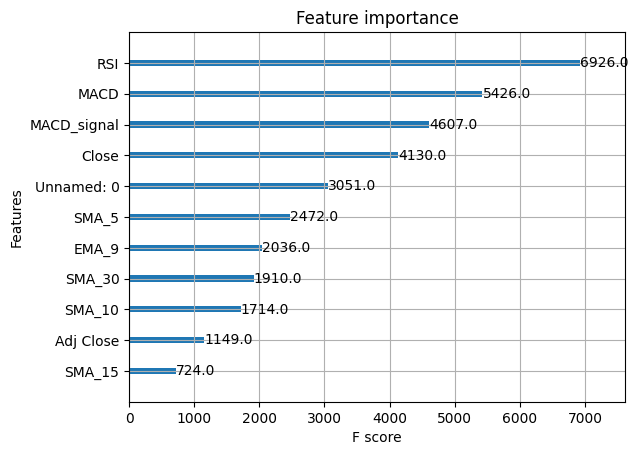

In [59]:
plot_importance(model);

store model

In [60]:
model.save_model("model.bin")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[21:39:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.



### Calculate and visualize predictions

In [61]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [0 1 1 0 1]
y_pred = [1 1 1 1 1]


In [62]:
# Filter data for the test period
test_data = df.loc[test_split_idx+1:].copy()
test_data['Predictions'] = y_pred  # Store predictions in a new column

# Create a scatter plot for the actual prices (test data only)
fig = go.Figure(data=[go.Scatter(x=test_data.Date, y=test_data.Close, name='Truth', marker_color='LightSkyBlue')])

# Add markers for buy and sell signals (test data only)
buy_indices = test_data[test_data['Predictions'] == 1].index
sell_indices = test_data[test_data['Predictions'] == 0].index

fig.add_trace(go.Scatter(x=test_data.Date.loc[buy_indices],
                         y=test_data.Close.loc[buy_indices],
                         mode='markers',
                         marker=dict(symbol='triangle-up', size=10, color='green'),
                         name='Buy'))

fig.add_trace(go.Scatter(x=test_data.Date.loc[sell_indices],
                         y=test_data.Close.loc[sell_indices],
                         mode='markers',
                         marker=dict(symbol='triangle-down', size=10, color='red'),
                         name='Sell'))

fig.show()

In [64]:
# Filter data for the test period
test_data = df.loc[test_split_idx+1:].copy()
test_data['Predictions'] = y_pred  # Store predictions in a new column

# Calculate daily returns
test_data['Returns'] = test_data['Close'].pct_change()

# Shift returns by one day to align with signal execution
test_data['Strategy_Returns'] = test_data['Predictions'].shift(1) * test_data['Returns']

# Calculate cumulative returns
test_data['Cumulative_Returns'] = (1 + test_data['Strategy_Returns']).cumprod()

# Calculate profitability
profitability = test_data['Cumulative_Returns'].iloc[-1] - 1

print(f"Profitability: {profitability:.2%}")

# Plot cumulative returns
fig = go.Figure(data=[go.Scatter(x=test_data.Date, y=test_data.Cumulative_Returns, name='Cumulative Returns')])
fig.show()

Profitability: -17.75%


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Accuracy: 0.5034013605442177
Precision: 0.48404255319148937
Recall: 0.65
F1-score: 0.5548780487804877


In [22]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()